In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-dataset/mtsamples_cleaned (1).csv
/kaggle/input/dataset-cleaned/mtsamples_cleaned (2).csv


In [2]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BartTokenizer, BartForConditionalGeneration
from torch.optim import AdamW
from tqdm import tqdm

2025-05-04 06:08:27.617704: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746338908.046539      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746338908.161585      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df = pd.read_csv('/kaggle/input/dataset-cleaned/mtsamples_cleaned (2).csv') 

In [4]:
df.head()

,transcription,medical_specialty,keywords,sentence_length
0,subjective yearold white female presents compl...,Allergy / Immunology,allergy immunology allergic rhinitis allergie...,204
1,past medical history difficulty climbing stair...,Bariatrics,bariatrics laparoscopic gastric bypass weight ...,350
2,history present illness seen abc today pleasan...,Bariatrics,bariatrics laparoscopic gastric bypass heart a...,716
3,mmode left atrial enlargement left atrial diam...,Cardiovascular / Pulmonary,cardiovascular pulmonary d mmode doppler aort...,68
4,left ventricular cavity size wall thickness ap...,Cardiovascular / Pulmonary,cardiovascular pulmonary d doppler echocardio...,229


In [5]:
# Define a custom dataset
class ClinicalSummaryDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_input_length=512, max_output_length=150):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.texts = dataframe['transcription']
        self.targets = dataframe['keywords']  # Assuming keywords are used as summaries. Adjust if needed.
        self.max_input_length = max_input_length
        self.max_output_length = max_output_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        input_text = str(self.texts[idx])
        target_text = str(self.targets[idx])

        # Tokenize inputs and targets
        input_encoding = self.tokenizer(
            input_text,
            padding='max_length',
            truncation=True,
            max_length=self.max_input_length,
            return_tensors="pt"
        )

        target_encoding = self.tokenizer(
            target_text,
            padding='max_length',
            truncation=True,
            max_length=self.max_output_length,
            return_tensors="pt"
        )

        return {
            'input_ids': input_encoding['input_ids'].squeeze(),
            'attention_mask': input_encoding['attention_mask'].squeeze(),
            'labels': target_encoding['input_ids'].squeeze()
        }

In [6]:
# Load BART tokenizer and model
model_name = 'facebook/bart-base'  # You can also try 'facebook/bart-large'
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [8]:
# Prepare dataset and dataloader
dataset = ClinicalSummaryDataset(df, tokenizer)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

In [9]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

In [10]:
# Training Loop
epochs = 10  # You can increase it if needed
model.train()

train_losses = []  # <-- NEW: to store average losses

for epoch in range(epochs):
    print(f'Epoch {epoch+1}')
    epoch_loss = 0
    
    for batch in tqdm(train_loader):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)   

    print(f'Average Loss: {avg_loss:.4f}')

Epoch 1


100%|██████████| 1242/1242 [08:36<00:00,  2.40it/s]


Average Loss: 0.7331
Epoch 2


100%|██████████| 1242/1242 [08:40<00:00,  2.39it/s]


Average Loss: 0.3711
Epoch 3


100%|██████████| 1242/1242 [08:40<00:00,  2.39it/s]


Average Loss: 0.3094
Epoch 4


100%|██████████| 1242/1242 [08:38<00:00,  2.39it/s]


Average Loss: 0.2488
Epoch 5


100%|██████████| 1242/1242 [08:39<00:00,  2.39it/s]


Average Loss: 0.2049
Epoch 6


100%|██████████| 1242/1242 [08:38<00:00,  2.39it/s]


Average Loss: 0.1697
Epoch 7


100%|██████████| 1242/1242 [08:38<00:00,  2.40it/s]


Average Loss: 0.1239
Epoch 8


100%|██████████| 1242/1242 [08:39<00:00,  2.39it/s]


Average Loss: 0.1029
Epoch 9


100%|██████████| 1242/1242 [08:38<00:00,  2.39it/s]


Average Loss: 0.0835
Epoch 10


100%|██████████| 1242/1242 [08:39<00:00,  2.39it/s]

Average Loss: 0.0725


In [11]:
# Save model
model.save_pretrained('/kaggle/working/clinical_bart_model')
tokenizer.save_pretrained('/kaggle/working/clinical_bart_model')

print("Model saved successfully!")

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Model saved successfully!


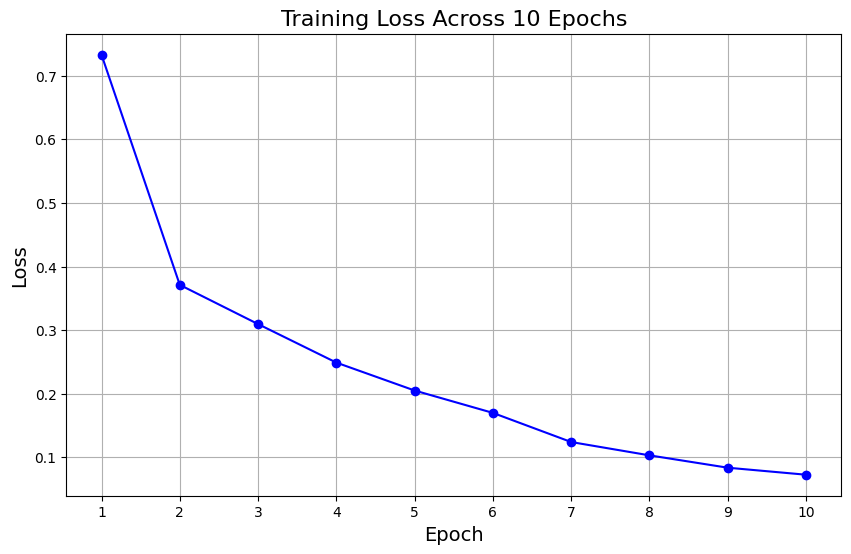

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', linestyle='-', color='blue')
plt.title('Training Loss Across 10 Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(range(1, len(train_losses)+1))
plt.grid(True)
plt.show()

In [13]:
# Load the model (if not already loaded)
from transformers import BartTokenizer, BartForConditionalGeneration

model_dir = '/kaggle/working/clinical_bart_model'

tokenizer = BartTokenizer.from_pretrained(model_dir)
model = BartForConditionalGeneration.from_pretrained(model_dir)
model = model.to(device)
model.eval()

# Function to generate summaries
def generate_summary(text, max_input_length=512, max_output_length=150):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        max_length=max_input_length,
        truncation=True
    ).to(device)
    
    summary_ids = model.generate(
        inputs["input_ids"],
        max_length=max_output_length,
        num_beams=4,
        early_stopping=True
    )
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Example: Generate summaries for first few transcriptions
df['generated_summary'] = df['transcription'].apply(lambda x: generate_summary(x))

In [24]:
df.to_csv("/kaggle/working/dataset_with_summaries.csv", index=False)

In [14]:
# Example 1: Generate summary for a single sentence
example_text = """The patient is a 67-year-old male with a history of hypertension and type 2 diabetes mellitus who presents with chest pain radiating to the left arm. An ECG showed ST-segment elevation consistent with myocardial infarction."""
example_summary = generate_summary(example_text)
print("Example Summary:\n", example_summary)

Example Summary:
67-year-old male with hypertension and diabetes presents with chest pain; ECG indicates myocardial infarction.


In [17]:
!pip install -q transformers bert-score nltk rouge-score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.6 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but yo

In [18]:
import numpy as np
import nltk
from rouge_score import rouge_scorer
from bert_score import score
from tqdm import tqdm

# Setup - Correct the columns first
references = df['keywords'].fillna('').astype(str).tolist()           # Ground truth
candidates = df['generated_summary'].fillna('').astype(str).tolist()   # Model output

# Initialize ROUGE scorer
rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Lists to store individual scores
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

# Calculate ROUGE for each sample
for ref, cand in tqdm(zip(references, candidates), total=len(references)):
    r_scores = rouge.score(ref, cand)
    rouge1_scores.append(r_scores['rouge1'].fmeasure)
    rouge2_scores.append(r_scores['rouge2'].fmeasure)
    rougeL_scores.append(r_scores['rougeL'].fmeasure)

# --- Filter out empty references or candidates before BERTScore ---
filtered_references = []
filtered_candidates = []

for ref, cand in zip(references, candidates):
    if ref.strip() != "" and cand.strip() != "":
        filtered_references.append(ref)
        filtered_candidates.append(cand)

# Calculate BERTScore only on valid pairs
P, R, F1 = score(filtered_candidates, filtered_references, lang="en", verbose=True)
bert_score_p = P.tolist()
bert_score_r = R.tolist()
bert_score_f1 = F1.tolist()

# Final metrics dictionary
metrics = {
    'rouge-1': np.mean(rouge1_scores),
    'rouge-2': np.mean(rouge2_scores),
    'rouge-l': np.mean(rougeL_scores),
    'bertscore-precision': np.mean(bert_score_p),
    'bertscore-recall': np.mean(bert_score_r),
    'bertscore-f1': np.mean(bert_score_f1)
}

# Print neatly
for metric_name, value in metrics.items():
    print(f"{metric_name}: {value:.4f}")

100%|██████████| 4966/4966 [00:03<00:00, 1357.76it/s]


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/84 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/60 [00:00<?, ?it/s]

done in 51.55 seconds, 73.89 sentences/sec
rouge-1: 0.6046
rouge-2: 0.5515
rouge-l: 0.5915
bertscore-precision: 0.9487
bertscore-recall: 0.9399
bertscore-f1: 0.9440
